# Makinig Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

In [2]:
common_access_point_names = ["Hamada-1", "Hamada-a", "Hamada-b", "Hamada-c", "Hamada-d", "Hamada-w", "Hamada-x", "Hamada-y", "Hamada-z"]
common_device_names = ["101", "102", "103", "104", "105", "106", "107", "108", "109", "110"]
measurements_header = ["Timestamp", "RSSI", "RTT"]

columns = []
for ap_name in common_access_point_names:
    for mm_name in measurements_header:
        columns.append(f"{ap_name}_{mm_name}")
print(columns)

['Hamada-1_Timestamp', 'Hamada-1_RSSI', 'Hamada-1_RTT', 'Hamada-a_Timestamp', 'Hamada-a_RSSI', 'Hamada-a_RTT', 'Hamada-b_Timestamp', 'Hamada-b_RSSI', 'Hamada-b_RTT', 'Hamada-c_Timestamp', 'Hamada-c_RSSI', 'Hamada-c_RTT', 'Hamada-d_Timestamp', 'Hamada-d_RSSI', 'Hamada-d_RTT', 'Hamada-w_Timestamp', 'Hamada-w_RSSI', 'Hamada-w_RTT', 'Hamada-x_Timestamp', 'Hamada-x_RSSI', 'Hamada-x_RTT', 'Hamada-y_Timestamp', 'Hamada-y_RSSI', 'Hamada-y_RTT', 'Hamada-z_Timestamp', 'Hamada-z_RSSI', 'Hamada-z_RTT']


# Build Model

In [3]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight_matrix):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight_matrix = weight_matrix

    def forward(self, inputs, targets):
        batch_size = inputs.size(0)
        num_classes = inputs.size(1)

        # One-hot encode targets
        # targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()
        targets_one_hot = targets

        # Calculate log probabilities
        log_probs = F.log_softmax(inputs, dim=1)

        # Calculate weighted cross-entropy loss
        loss = -targets_one_hot * log_probs

        # Apply weights to the loss
        expanded_weight_matrix = self.weight_matrix.unsqueeze(0).expand(batch_size, -1, -1)
        weighted_loss = torch.bmm(loss.unsqueeze(1), expanded_weight_matrix).squeeze()

        # Sum over classes and average over batch
        loss = weighted_loss.sum(dim=1).mean()

        return loss

# 重み行列の定義（例）
num_classes = 25
weight_matrix = torch.ones((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        weight_matrix[i, j] = abs(i - j)/5.0  # クラス間の距離に基づく重み
weight_matrix = weight_matrix.to(device)

In [5]:
from torch import nn
from torch.nn import functional as F
from torch import nn, Tensor
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
from torch import optim
import time
import torch.nn.init as init

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, positional_max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(positional_max_len, d_model)
        position = torch.arange(0, positional_max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:, 0:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Net(nn.Module):
    def __init__(self, num_of_features, num_of_reference_point, num_layers, max_len, dim_feedforward=256):
        super().__init__()

        self.num_of_features = num_of_features
        self.max_len = max_len

        self.cnn_output_channels = 64

        # Define Conv1D layers
        self.conv1 = nn.Conv1d(in_channels=num_of_features, out_channels=128, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, self.cnn_output_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(self.cnn_output_channels)
        self.conv3 = nn.Conv1d(self.cnn_output_channels, self.cnn_output_channels, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(self.cnn_output_channels)
        self.conv4 = nn.Conv1d(self.cnn_output_channels, self.cnn_output_channels, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(self.cnn_output_channels)

        self.pos_encoder = PositionalEncoding(self.cnn_output_channels, positional_max_len=self.max_len)  # Update input dimension for PositionalEncoding
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.cnn_output_channels, nhead=2, dim_feedforward=dim_feedforward)  # Update d_model
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers, enable_nested_tensor=False)

        self.fc4 = nn.Linear(self.cnn_output_channels * self.max_len, self.cnn_output_channels)  # Update input size according to Conv1D output
        self.fc5 = nn.Linear(self.cnn_output_channels, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(64, num_of_reference_point)

        self.dropout = nn.Dropout(p=0.2)

        # self.criterion = WeightedCrossEntropyLoss(weight_matrix)
        self.criterion_cross_entropy = nn.CrossEntropyLoss(reduction='mean')
        self.criterion_multi_label = torch.nn.MultiLabelSoftMarginLoss()
        self.criterion = torch.nn.MultiLabelSoftMarginLoss()
        # self.criterion = CustomLoss(penalty_weight=3.0)
        self.criterion_mse = torch.nn.MSELoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=0.0001)
        self._reset_parameters()

    def _reset_parameters(self):
        # Initialize Conv1d layers
        init.xavier_uniform_(self.conv1.weight)
        if self.conv1.bias is not None:
            init.constant_(self.conv1.bias, 0)

        # Initialize BatchNorm layers
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        
        init.xavier_uniform_(self.conv2.weight)
        if self.conv2.bias is not None:
            init.constant_(self.conv2.bias, 0)

        # Initialize BatchNorm layers
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        
        init.xavier_uniform_(self.conv3.weight)
        if self.conv3.bias is not None:
            init.constant_(self.conv3.bias, 0)

        # Initialize BatchNorm layers
        init.constant_(self.bn3.weight, 1)
        init.constant_(self.bn3.bias, 0)
        
        init.xavier_uniform_(self.conv4.weight)
        if self.conv4.bias is not None:
            init.constant_(self.conv4.bias, 0)

        # Initialize BatchNorm layers
        init.constant_(self.bn4.weight, 1)
        init.constant_(self.bn4.bias, 0)

        # Initialize Transformer Encoder Layer
        for layer in self.transformer_encoder.layers:
            init.xavier_uniform_(layer.self_attn.in_proj_weight)
            if layer.self_attn.in_proj_bias is not None:
                init.constant_(layer.self_attn.in_proj_bias, 0)

            init.xavier_uniform_(layer.self_attn.out_proj.weight)
            if layer.self_attn.out_proj.bias is not None:
                init.constant_(layer.self_attn.out_proj.bias, 0)

            init.xavier_uniform_(layer.linear1.weight)
            if layer.linear1.bias is not None:
                init.constant_(layer.linear1.bias, 0)

            init.xavier_uniform_(layer.linear2.weight)
            if layer.linear2.bias is not None:
                init.constant_(layer.linear2.bias, 0)

            # Initialize LayerNorm
            init.constant_(layer.norm1.weight, 1)
            init.constant_(layer.norm1.bias, 0)
            init.constant_(layer.norm2.weight, 1)
            init.constant_(layer.norm2.bias, 0)

        # Initialize Linear layers
        init.xavier_uniform_(self.fc4.weight)
        if self.fc4.bias is not None:
            init.constant_(self.fc4.bias, 0)

        init.xavier_uniform_(self.fc7.weight)
        if self.fc7.bias is not None:
            init.constant_(self.fc7.bias, 0)

    
    def forward(self, x):
        start = time.perf_counter()
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_features, seq_len) for Conv1D
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        # x = F.relu(self.bn4(self.conv4(x)))
        # print(time.perf_counter() - start)
        
        x = x.permute(2, 0, 1)  # Change shape to (seq_len, batch_size, num_features) for Transformer
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # print(time.perf_counter() - start)
        
        x = torch.flatten(x.permute(1, 0, 2), start_dim=1)
        x = self.fc4(x)
        x = self.dropout(self.fc5(x))
        x = F.relu(x)
        x = self.fc7(x)
        # print(time.perf_counter() - start)
        return x


## Create Train/Test dataset

In [6]:
max_sequence_length = 8

In [ ]:
import re

df = pd.read_csv("/home/RTT_RSSI_student_room_one_person/sample_data.csv")
# print(df.columns.values.tolist())
RTT_columns = [s for s in df.columns.values.tolist() if re.match('.*RTT*', s)]
RSSI_columns = [s for s in df.columns.values.tolist() if re.match('.*_RSSI*', s)]
print(len(RTT_columns))
print(len(RSSI_columns))

81
81


/tmp/ipykernel_6340/3194044685.py:3: DtypeWarning: Columns (32,35,38,41,47,50,53,56,167,170,173,176,179,182,185,188,191) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/RTT_RSSI_student_room_one_person/humanpos_merged.csv")


In [8]:
print(df.columns)

Index(['devicepositionID', 'humanpositionID', 'X', 'Y',
       'Hamada-1_timestamp_101', 'Hamada-1_RSSI_101', 'Hamada-1_RTT_101',
       'Hamada-a_timestamp_101', 'Hamada-a_RSSI_101', 'Hamada-a_RTT_101',
       ...
       'Hamada-w_RTT_110', 'Hamada-x_timestamp_110', 'Hamada-x_RSSI_110',
       'Hamada-x_RTT_110', 'Hamada-y_timestamp_110', 'Hamada-y_RSSI_110',
       'Hamada-y_RTT_110', 'Hamada-z_timestamp_110', 'Hamada-z_RSSI_110',
       'Hamada-z_RTT_110'],
      dtype='object', length=248)


In [9]:
positions = [str(i) for i in range(20)]
print(positions)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import glob
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Original dataset lists
training_dataset_list = []
training_label_list = []
testing_dataset_list = []
testing_label_list = []

# file_paths = glob.glob("preprocessed_dataset/*/*_adjust_sequence_length.csv")
file_paths = glob.glob("/home/RTT_RSSI_student_room_one_person/sample_data.csv")


for file_path in tqdm(file_paths):
    df = pd.read_csv(file_path)
    drop_cols = ["Hamada-d_timestamp_102", "Hamada-d_RTT_102", "Hamada-d_RSSI_102", 
                 "Hamada-w_timestamp_102", "Hamada-w_RTT_102", "Hamada-w_RSSI_102"]
    df = df.drop(columns=drop_cols)
    
    # 数値型カラムだけ抽出するための関数
    def get_numeric_columns(df):
        return df.select_dtypes(include=["float64", "float32", "int64", "int32"]).columns
    
    # NaN補完処理
    def fillna_with_local_mean(group, window=10):
        filled_group = group.copy()
        numeric_cols = get_numeric_columns(group)
    
        for col in numeric_cols:
            na_indices = group[col].isna()
            for idx in group[na_indices].index:
                start = max(idx - window, group.index.min())
                end = min(idx + window + 1, group.index.max() + 1)
                local_window = group.loc[start:end, col]
                local_mean = local_window.dropna().mean()
                if not np.isnan(local_mean):
                    filled_group.at[idx, col] = local_mean
        return filled_group
    
    # humanpositionIDごとに補完処理
    df_filled = df.groupby("humanpositionID", group_keys=False).apply(fillna_with_local_mean).reset_index(drop=True)
    
    # 残ったNaN行を削除
    df_filled = df_filled.dropna(axis=1).dropna().reset_index(drop=True)


    RTT_columns = [s for s in df_filled.columns.values.tolist() if re.match('.*RTT*', s)]
    RSSI_columns = [s for s in df_filled.columns.values.tolist() if re.match('.*_RSSI*', s)]

    # x_RTT extraction
    x_RTT = df_filled[RTT_columns]
    # y = df["humanpositionID"]

    # Get noise indexes
    removal_indexes = set()
    removal_indexes = removal_indexes.union(set(x_RTT.index[(x_RTT <= 0.0).any(axis=1)]))
    removal_indexes = removal_indexes.union(set(x_RTT.index[(x_RTT >= 1.0*10**(-7)).any(axis=1)]))

    # Drop noisy data
    df = df_filled.drop(df_filled.index[list(removal_indexes)])

    # Data Augmentation
    def add_gaussian_noise(data, mean=0.0, std=0.001):
        noise = torch.normal(mean=mean, std=std, size=data.size())
        return data + noise

    def time_shift(data, shift):
        return torch.roll(data, shifts=shift, dims=0)

    def scale_data(data, scale_factor):
        return data * scale_factor


    # humanpositionID ごとに DataFrame を分割して辞書に格納
    df_dict = {position_id: group_df.reset_index(drop=True)
               for position_id, group_df in df.groupby("humanpositionID")}

    for position_id, group_df in df_dict.items():

        x_RTT = group_df[RTT_columns]
        # y = df["humanpositionID"]
        # Normalize and convert to tensors
        x_RTT = x_RTT.to_numpy().astype("float32") * (10.0 ** 7)
        # y = y.to_numpy().astype("int")
        x_RTT = torch.from_numpy(x_RTT)
        # y = torch.from_numpy(y)

        one_hot_array = np.zeros((1, 20), dtype=np.float32)
        one_hot_array[np.arange(1), position_id - 1] = 1.0
        one_hot_array = torch.tensor(one_hot_array, dtype=torch.float32)
            
        for data_index in range(int(len(x_RTT) * 0.8) - max_sequence_length):

            
            x_segment = x_RTT[data_index:data_index + max_sequence_length]
    
            # Original data
            training_dataset_list.append(x_segment)
            training_label_list.append(one_hot_array)
    
            # Augmentation: Gaussian Noise
            noisy_data = add_gaussian_noise(x_segment)
            training_dataset_list.append(noisy_data)
            training_label_list.append(one_hot_array)
    
            noisy_data = add_gaussian_noise(x_segment, std=0.0005)
            training_dataset_list.append(noisy_data)
            training_label_list.append(one_hot_array)
    
            # # Augmentation: Time Shift
            # shifted_data = time_shift(x_segment, shift=1)  # Shift by 1 timestep
            # training_dataset_list.append(shifted_data)
            # training_label_list.append(y[0])
    
            # Augmentation: Scaling
            # scaled_data = scale_data(x_segment, scale_factor=np.random.uniform(0.9, 1.1))
            # training_dataset_list.append(scaled_data)
            # training_label_list.append(y[0])
    
        for data_index in range(int(len(x_RTT) * 0.8), len(x_RTT) - max_sequence_length):
            x_segment = x_RTT[data_index:data_index + max_sequence_length]
    
            # Original data
            testing_dataset_list.append(x_segment)
            testing_label_list.append(one_hot_array)

print(len(training_dataset_list))
print(len(testing_dataset_list))

  0%|                                                                                                                                    | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_6340/302950076.py:33: DtypeWarning: Columns (32,35,38,41,47,50,53,56,167,170,173,176,179,182,185,188,191) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby("humanpositionID", group_keys=False).apply(fillna_with_local_mean).reset_index(drop=True)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.03s/it

31167
2498


In [11]:
df_filled

,devicepositionID,humanpositionID,X,Y,Hamada-1_RSSI_101,Hamada-1_RTT_101,Hamada-a_RSSI_101,Hamada-a_RTT_101,Hamada-b_RSSI_101,Hamada-b_RTT_101,...,Hamada-d_RSSI_110,Hamada-d_RTT_110,Hamada-w_RSSI_110,Hamada-w_RTT_110,Hamada-x_RSSI_110,Hamada-x_RTT_110,Hamada-y_RSSI_110,Hamada-y_RTT_110,Hamada-z_RSSI_110,Hamada-z_RTT_110
0,101,2,1851.0,4036.0,-60.000000,2.791264e-08,-58.0,1.960690e-08,-51.000000,1.742872e-08,...,-65.0,4.052470e-08,-76.0,7.615602e-08,-66.0,2.087778e-08,-68.0,4.537472e-08,-65.0,4.674234e-08
1,101,2,1851.0,4036.0,-60.000000,2.752237e-08,-58.0,1.960023e-08,-51.000000,1.723192e-08,...,-65.0,4.052470e-08,-76.0,7.615602e-08,-66.0,2.087778e-08,-68.0,4.537472e-08,-65.0,4.674234e-08
2,101,2,1851.0,4036.0,-61.000000,2.804273e-08,-56.0,1.955019e-08,-51.000000,1.842942e-08,...,-65.0,4.052470e-08,-76.0,7.615602e-08,-66.0,2.087778e-08,-68.0,4.537472e-08,-65.0,4.674234e-08
3,101,2,1851.0,4036.0,-60.357143,2.754787e-08,-58.0,1.925165e-08,-51.428571,1.761576e-08,...,-65.0,5.261640e-08,-77.0,8.172654e-08,-65.0,2.061760e-08,-68.0,4.556819e-08,-66.0,4.459085e-08
4,101,2,1851.0,4036.0,-60.000000,2.778255e-08,-58.0,1.882636e-08,-51.000000,1.882636e-08,...,-65.0,4.107842e-08,-77.0,7.625275e-08,-64.0,2.113796e-08,-68.0,4.566492e-08,-66.0,4.120184e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,101,20,1851.0,4036.0,-63.000000,2.726219e-08,-57.0,2.047416e-08,-52.000000,1.969362e-08,...,-66.0,4.280628e-08,-76.0,7.840424e-08,-65.0,6.061860e-08,-69.0,4.674234e-08,-64.0,4.713261e-08
13517,101,20,1851.0,4036.0,-63.000000,2.778255e-08,-57.0,2.054088e-08,-52.000000,1.968028e-08,...,-66.0,4.321323e-08,-75.0,7.716672e-08,-64.0,6.139914e-08,-69.0,4.683907e-08,-63.0,4.680571e-08
13518,101,20,1851.0,4036.0,-63.000000,2.726219e-08,-57.0,2.050085e-08,-52.000000,1.960690e-08,...,-66.0,4.257946e-08,-76.0,7.762370e-08,-65.0,6.052187e-08,-69.0,4.683907e-08,-64.0,4.693580e-08
13519,101,20,1851.0,4036.0,-63.000000,2.765246e-08,-57.0,2.056423e-08,-52.000000,2.214532e-08,...,-66.0,4.268620e-08,-76.0,7.762370e-08,-65.0,6.139914e-08,-69.0,4.674234e-08,-64.0,4.703587e-08


In [12]:
# humanpositionID ごとに DataFrame を分割して辞書に格納
df_dict = {position_id: group_df.reset_index(drop=True)
           for position_id, group_df in df_filled.groupby("humanpositionID")}
df_dict.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [13]:
training_dataset_list[0]

tensor([[0.2791, 0.1961, 0.1743, 0.3522, 0.4907, 0.6570, 0.5853, 0.7195, 0.5143,
         0.2817, 0.4440, 0.1981, 0.4845, 0.0543, 0.3234, 0.3648, 0.2765, 0.2856,
         0.3195, 0.2227, 0.2668, 0.2338, 0.4675, 0.8876, 0.4137, 0.6316, 0.4498,
         0.2817, 0.4209, 0.1997, 0.4900, 0.1300, 0.2974, 0.1830, 0.2856, 0.0658,
         0.5174, 0.6098, 0.3852, 0.6319, 0.2916, 0.1085, 0.4570, 0.0677, 0.2824,
         0.1996, 0.4285, 0.2577, 0.5066, 0.2447, 0.5769, 0.0511, 0.3326, 0.1488,
         0.2856, 0.4628, 0.3268, 0.2451, 0.4052, 0.7616, 0.2088, 0.4537, 0.4674],
        [0.2752, 0.1960, 0.1723, 0.3644, 0.4800, 0.6570, 0.5905, 0.7130, 0.5153,
         0.2847, 0.4273, 0.1979, 0.4949, 0.0540, 0.3257, 0.3668, 0.2869, 0.2944,
         0.3195, 0.2227, 0.2668, 0.2338, 0.4675, 0.8876, 0.4137, 0.6316, 0.4498,
         0.2817, 0.4209, 0.1997, 0.4900, 0.1300, 0.2974, 0.1830, 0.2856, 0.0658,
         0.5148, 0.6100, 0.3854, 0.6319, 0.2924, 0.1083, 0.4531, 0.0677, 0.2822,
         0.1918, 0.4248, 0.

In [14]:
training_label_list[2000]

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

## Training

In [15]:
# 損失関数と最適化関数
from torch import optim

def get_batched_list(list_obj, batch_size):

    retval = []
    for idx in range(0, len(list_obj), batch_size):
        retval.append(list_obj[idx:idx + batch_size])
    return retval
 

def train_on_batch(model, dataset_list, label_list, batch_size=32):

    model.train()

    model = model.to(device)

    batched_training_dataset = get_batched_list(dataset_list, batch_size)
    batched_label_dataset = get_batched_list(label_list, batch_size)
    loss_mean = 0
    # ミニバッチごとにループさせる,train_loaderの中身を出し切ったら1エポックとなる
    for i in range(len(batched_training_dataset)):
        # print(len(batched_training_dataset[i]))
        # print(batched_training_dataset[i][0].shape)
        # print(torch.cat(batched_training_dataset[i]).shape)
        # print(torch.stack(batched_training_dataset[i]).shape)
        data = batched_training_dataset[i]
        # print(torch.stack(data).size())
        y = model(torch.stack(data).to(device)) # 順伝播
        y = y.squeeze_()
        label = batched_label_dataset[i]
        t = torch.stack(label).squeeze_()
        # print(y.size())
        # print(t.size())
        model.optimizer.zero_grad()  # 勾配を初期化（前回のループ時の勾配を削除）
        # print(y.size())
        loss = model.criterion(y.to(device), t.float().to(device))  # 損失を計算
        # loss = model.criterion_multi_label(y.to(device), t.float().to(device)) * model.criterion_cross_entropy(y.to(device), t.float().to(device))
        # loss = model.criterion_multi_label(y.to(device), t.float().to(device)) * model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device))
        # loss = model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device)) * model.criterion_multi_label(y.to(device), t.float().to(device))
        # loss = model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device)) + model.criterion_multi_label(y.to(device), t.float().to(device))
        loss.backward()  # 逆伝播で勾配を計算
        model.optimizer.step()  # 最適化

        loss_mean += loss.item()

        # # ミニバッチごとの正答率と損失を求める
        # _, index_y = torch.max(y, axis=1)  # 最も確率が高いと予測したindex
        # # _, index_t = torch.max(t, axis=1)  # 正解のindex
        # print(index_y)
        # for i in range(len(t)):  # データ一つずつループ,ミニバッチの中身出しきるまで
        #     total_data_len += 1  # 全データ数を集計
        #     if index_y[i] == t[i]:
        #         total_correct += 1 # 正解のデータ数を集計

    loss_mean = loss_mean / len(batched_training_dataset)

    # return total_correct, total_data_len, loss_mean
    return loss_mean

def test_on_batch(model, dataset_list, label_list, batch_size=32):
    # モデルを評価モードにする
    model.eval()

    model = model.to(device)
    # # 正しい予測数、全体のデータ数を数えるカウンターの0初期化
    batched_testing_dataset = get_batched_list(dataset_list, batch_size)
    batched_label_dataset = get_batched_list(label_list, batch_size)
    
    loss_mean = 0
    for i in range(len(batched_testing_dataset)):
        data = batched_testing_dataset[i]
        y = model(torch.stack(data).to(device)) # 順伝播
        # print(y)
        # print(t)
        y = y.squeeze_()
        label = batched_label_dataset[i]
        t = torch.stack(label).squeeze_()
        # t = label_list[i].squeeze_()
        # print(y.size())
        # print(t.size())
        loss = model.criterion(y, t.float().to(device))  # 損失を計算
        # loss = model.criterion_multi_label(y.to(device), t.float().to(device)) * model.criterion_cross_entropy(y.to(device), t.float().to(device))
        # loss = model.criterion_multi_label(y.to(device), t.float().to(device)) * model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device))
        # loss = model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device))**model.criterion_multi_label(y.to(device), t.float().to(device))
        # loss = model.criterion_mse(torch.sum(torch.special.expit(y), dim=1).to(device), torch.sum(torch.special.expit(t.float()), dim=1).to(device)) + model.criterion_multi_label(y.to(device), t.float().to(device))
        loss_mean += loss.item()

    loss_mean = loss_mean / len(batched_testing_dataset)

    return loss_mean


In [16]:
import torch
import numpy as np
import random

seed = 2024

# Set the seed for PyTorch
torch.manual_seed(seed)

# If using CUDA, set the seed for CUDA as well
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

# Set the seed for numpy
np.random.seed(seed)

# Set the seed for Python's built-in random module
random.seed(seed)

# If you want deterministic behavior, set this as well
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
import random

p = list(zip(training_dataset_list, training_label_list))
random.shuffle(p)
training_dataset_list, training_label_list = zip(*p)

p = list(zip(testing_dataset_list, testing_label_list))
random.shuffle(p)
testing_dataset_list, testing_label_list = zip(*p)

In [32]:
import torch
from torchinfo import summary  # 後述する torchinfo を使う場合


# アーキテクチャのインスタンス作成
import copy

epochs = 500
batch_size = 2048
dim_feedforward = 128
num_layers = 3


if("model" in locals()):
    del model
    torch.cuda.empty_cache()
model = Net(len(RTT_columns), len(positions), num_layers, max_sequence_length, dim_feedforward=dim_feedforward).to(device)

torch.cuda.memory_allocated(device=None)   # 実際にアロケート（確保）されているメモリ量
torch.cuda.memory_reserved(device=None)    # PyTorch がキャッシュとして確保しているメモリ量


record_train_loss = []
record_test_loss = []
best_model = copy.deepcopy(model)
best_score = 9999
for epoch in range(epochs):
    
    train_loss = train_on_batch(model, training_dataset_list , training_label_list , batch_size=batch_size)
    test_loss = test_on_batch(model, testing_dataset_list, testing_label_list, batch_size=batch_size)

    # train_acc = train_correct_len/train_data_len*100
        # test_acc = test_correct_len/test_data_len*100

    record_train_loss.append(train_loss)
    record_test_loss.append(test_loss)

    if epoch%1 == 0:
        # print(f"epoch={epoch}, train:{train_correct_len}/{train_data_len}({train_acc:.2f}%), {train_loss:.5f}, test:{test_correct_len}/{test_data_len}({test_acc:.2f}%), {test_loss:.5f}")
        # print(f"epoch={epoch}, train:{train_loss:.8f}, test: {test_loss:.8f}", end=",")
        pass
    if(best_score >= train_loss):
        # print("update")
        pass
        best_score = train_loss
        best_model = copy.deepcopy(model)
    else:
        # print()
        pass

    # 1. 任意のタイミング（ここでは 100 ステップごと）でメモリ量を表示
    if epoch % 100 == 0:
        torch.cuda.synchronize()  # 非同期処理の完了待ち（正確な計測のため）
        allocated = torch.cuda.memory_allocated(device) / 1024**2
        reserved  = torch.cuda.memory_reserved(device)  / 1024**2
        print(f"[epoch {epoch:03d} step {epoch:04d}] "
              f"Allocated: {allocated:.1f} MiB, "
              f"Reserved:  {reserved:.1f} MiB")

[epoch 000 step 0000] Allocated: 69.2 MiB, Reserved:  390.0 MiB
[epoch 100 step 0100] Allocated: 69.2 MiB, Reserved:  394.0 MiB
200 step 0200] Allocated: 69.2 MiB, Reserved:  394.0 MiB

[epoch 300 step 0300] Allocated: 69.2 MiB, Reserved:  394.0 MiB
400 step 0400] Allocated: 69.2 MiB, Reserved:  394.0 MiB



In [19]:
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
        
print(params)  # 121898

280820


In [22]:
# torch.save(best_model.state_dict(), "./transformer_based_multi_label_classicifation_model.pth")
print(best_model.eval())

Net(
  (conv1): Conv1d(63, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dro

# Evaluation

### Classification

/tmp/ipykernel_6340/1140866789.py:72: RuntimeWarning: invalid value encountered in divide
  cmn = np.nan_to_num(a.astype('float')/a.sum(axis=1)[:, np.newaxis])


0.9871897518014412


IndexError: list index out of range

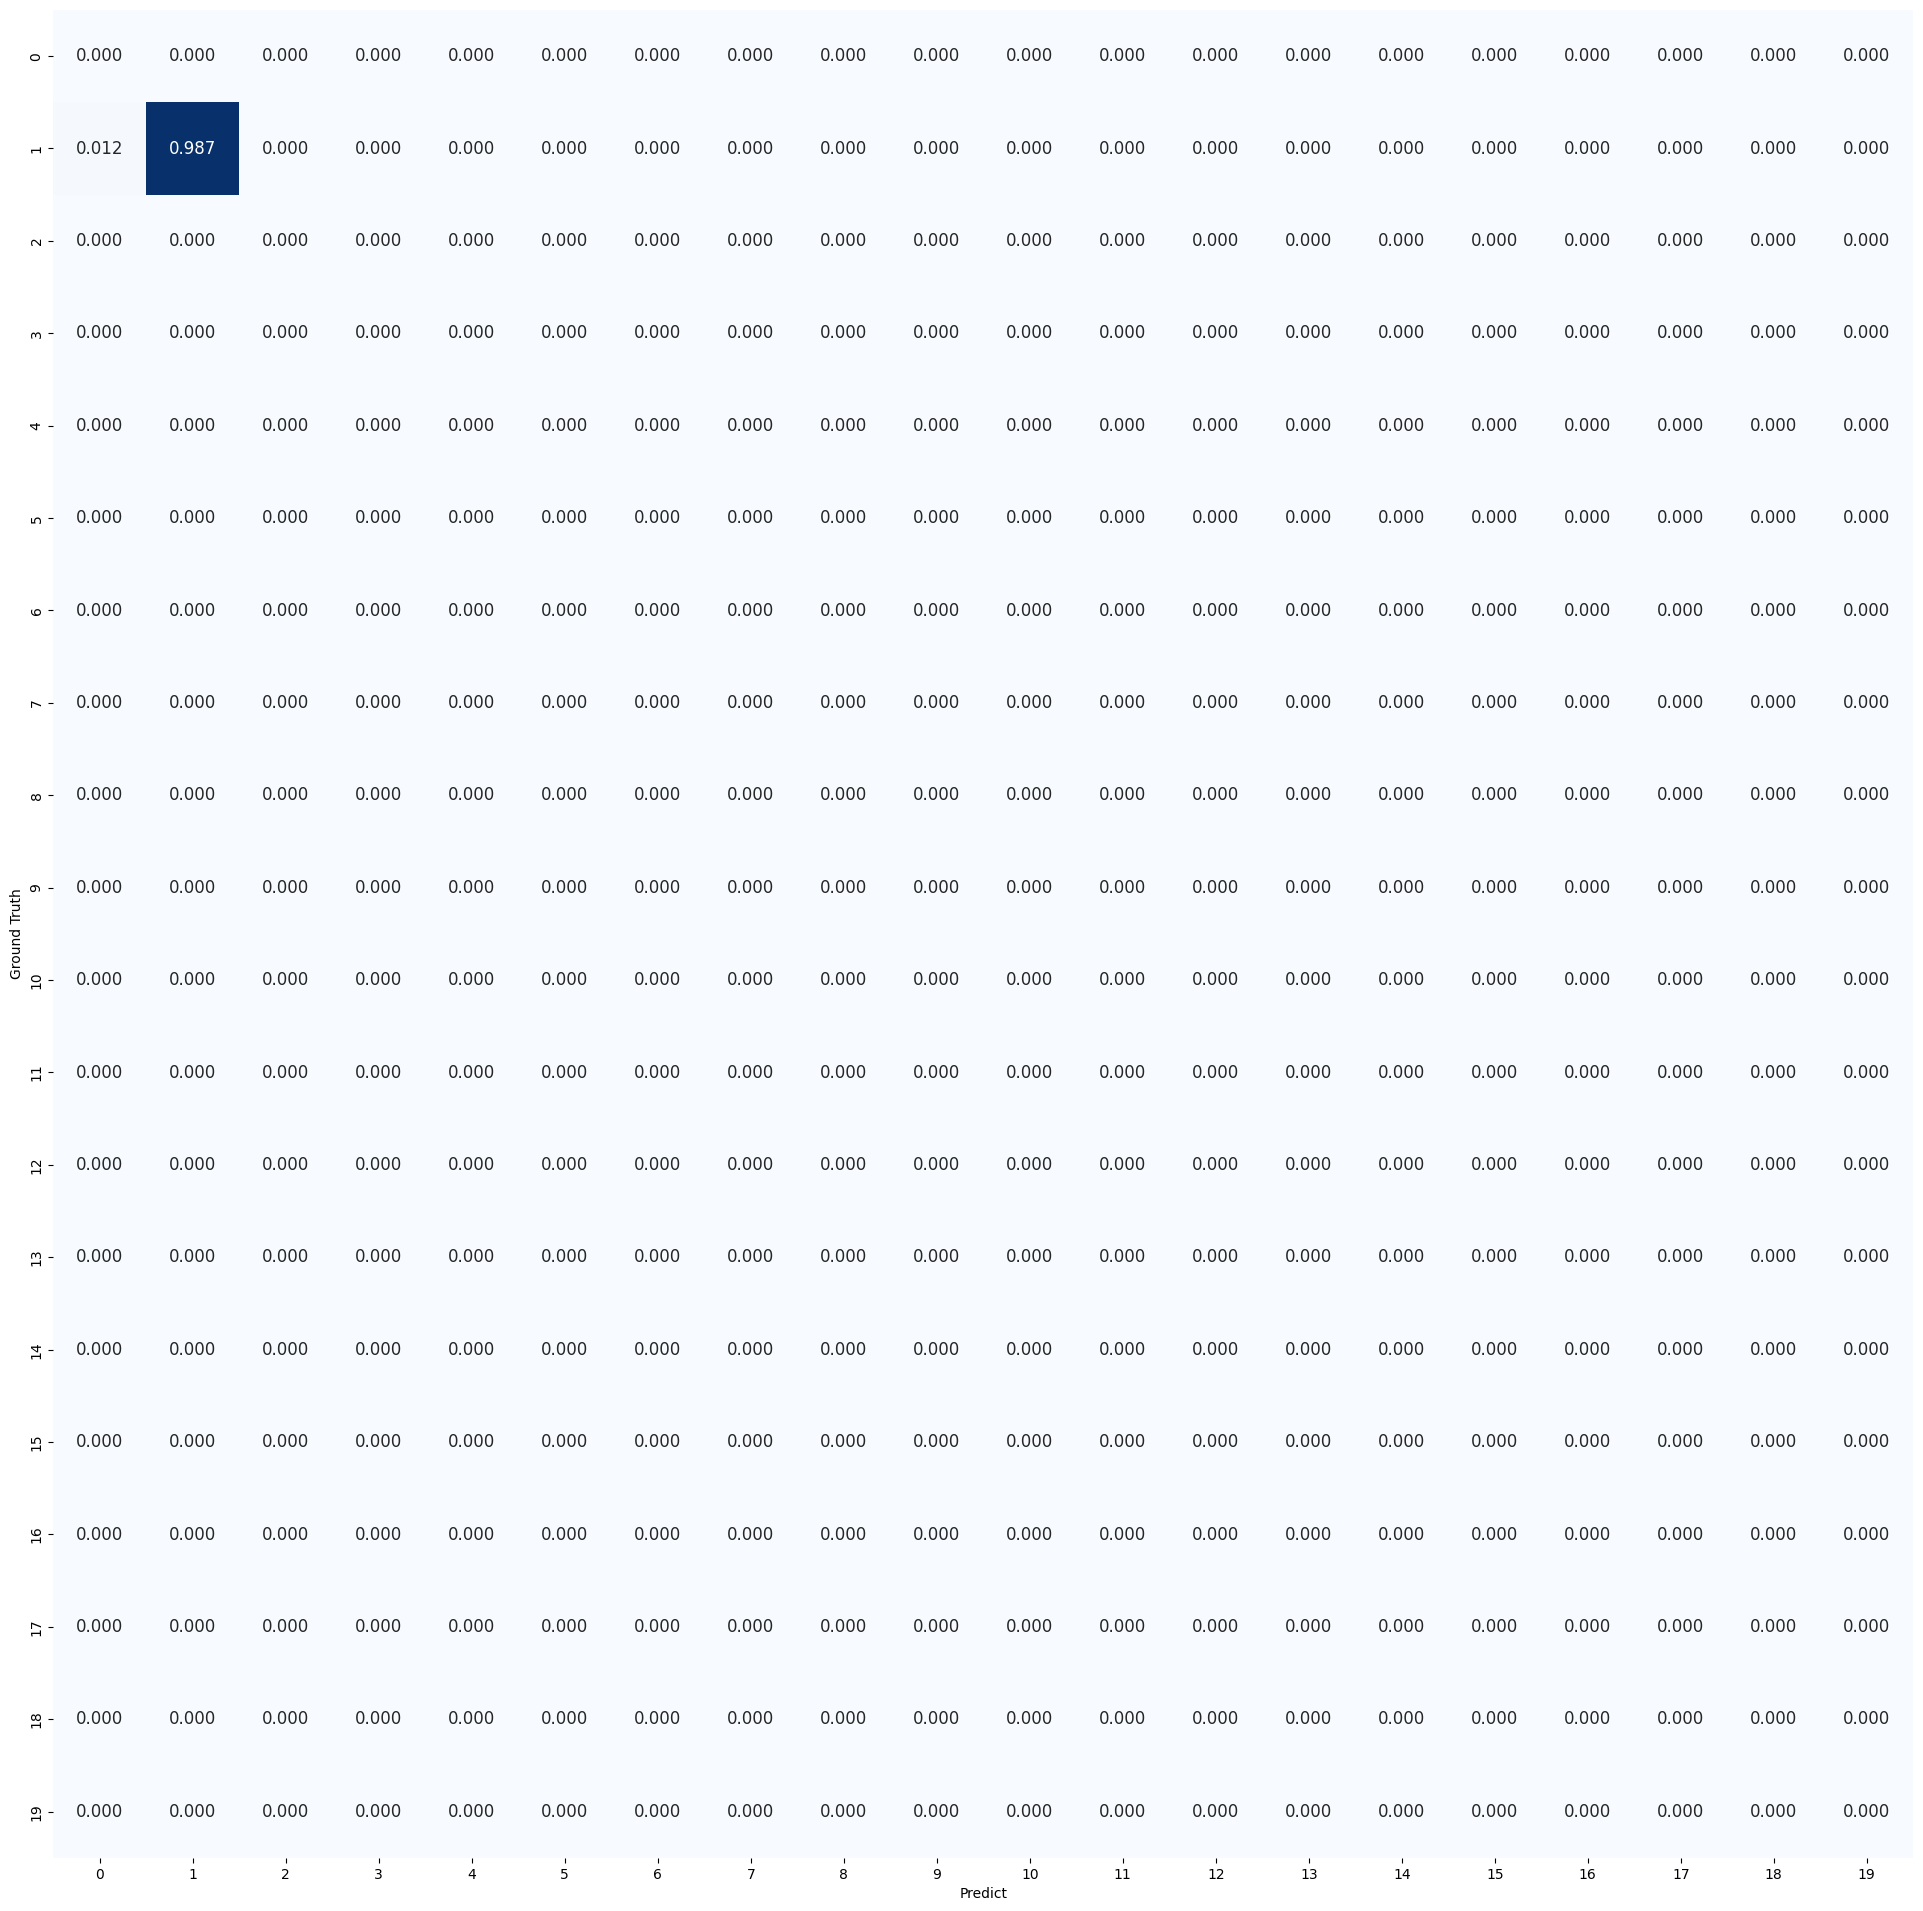

In [ ]:
import torch
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
def custom_threshold_function(x):
    # Apply thresholding logic
    return torch.where(x < 0.0, torch.tensor(0), torch.tensor(1))


# モデルを評価モードにする
best_model.eval()
model.eval()

# # 正しい予測数、全体のデータ数を数えるカウンターの0初期化
total_data_len = 0
total_correct = 0

loss_mean = 0

results = [[0 for _ in range(len(positions))] for __ in range(len(positions) )]

# 正しい予測数、全体のデータ数を数えるカウンターの0初期化
batched_testing_dataset = get_batched_list(testing_dataset_list, batch_size=batch_size)
# print(y_test)
batched_label_dataset = get_batched_list(testing_label_list, batch_size=batch_size)
# batched_testing_dataset = get_batched_list(training_dataset_list, batch_size=batch_size)
# batched_label_dataset = get_batched_list(training_label_list, batch_size=batch_size)
# print(batched_label_dataset)
# print(X_test)
# print(batched_training_dataset)

for i in range(len(batched_testing_dataset)):
    data = batched_testing_dataset[i]
    y = best_model(torch.stack(data).to(device)) # 順伝播
    # print(y)
    # print(t)    
    y = custom_threshold_function(y)

    label = batched_label_dataset[i]
    t = torch.stack(label).squeeze_()
    # print(int(torch.sum(y)))
    y = y.tolist()
    t = t.tolist()
    # print(y[:10])
    # print(t[:10])
    if(not isinstance(t[0],list)):
        t = [t]
    for _ in range(len(y)):
        results[int(sum(t[_]))][int(sum(y[_]))] += 1

    # break

# loss_mean = loss_mean / len(dataset_list)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# print(results)

plt.figure(figsize=(20, 20))
plt.rcParams["font.size"] = 10
# s = sns.heatmap(np.array(results)[:9, :9], cbar=False, fmt='d', annot=True, cmap='Blues')
# s.set(xlabel='Predict', ylabel='Ground Truth')
# plt.savefig('transformer_result.pdf')

a = np.array(results)[:21, :21]
cmn = np.nan_to_num(a.astype('float')/a.sum(axis=1)[:, np.newaxis])
s = sns.heatmap(cmn, cbar=False, fmt='.3f', annot=True, cmap='Blues', annot_kws={"fontsize":12})
s.set(xlabel='Predict', ylabel='Ground Truth')
# plt.savefig('transformer_result_.pdf')

correct = 0
for i in range(20):
    correct += results[i][i]
accuracy = correct/sum(sum(results,[]))
print(accuracy)

# 1つのエラーと2つのエラーの数を計算
one_error = 0
two_errors = 0

for i in range(20):
    for j in range(20):
        if i != j:
            diff = abs(i - j)
            if diff == 1:
                one_error += results[i][j]
            elif diff == 2:
                two_errors += results[i][j]

print("One Error Count:", one_error, one_error/sum(sum(results,[])))
print("Two Errors Count:", two_errors, two_errors/sum(sum(results,[])))

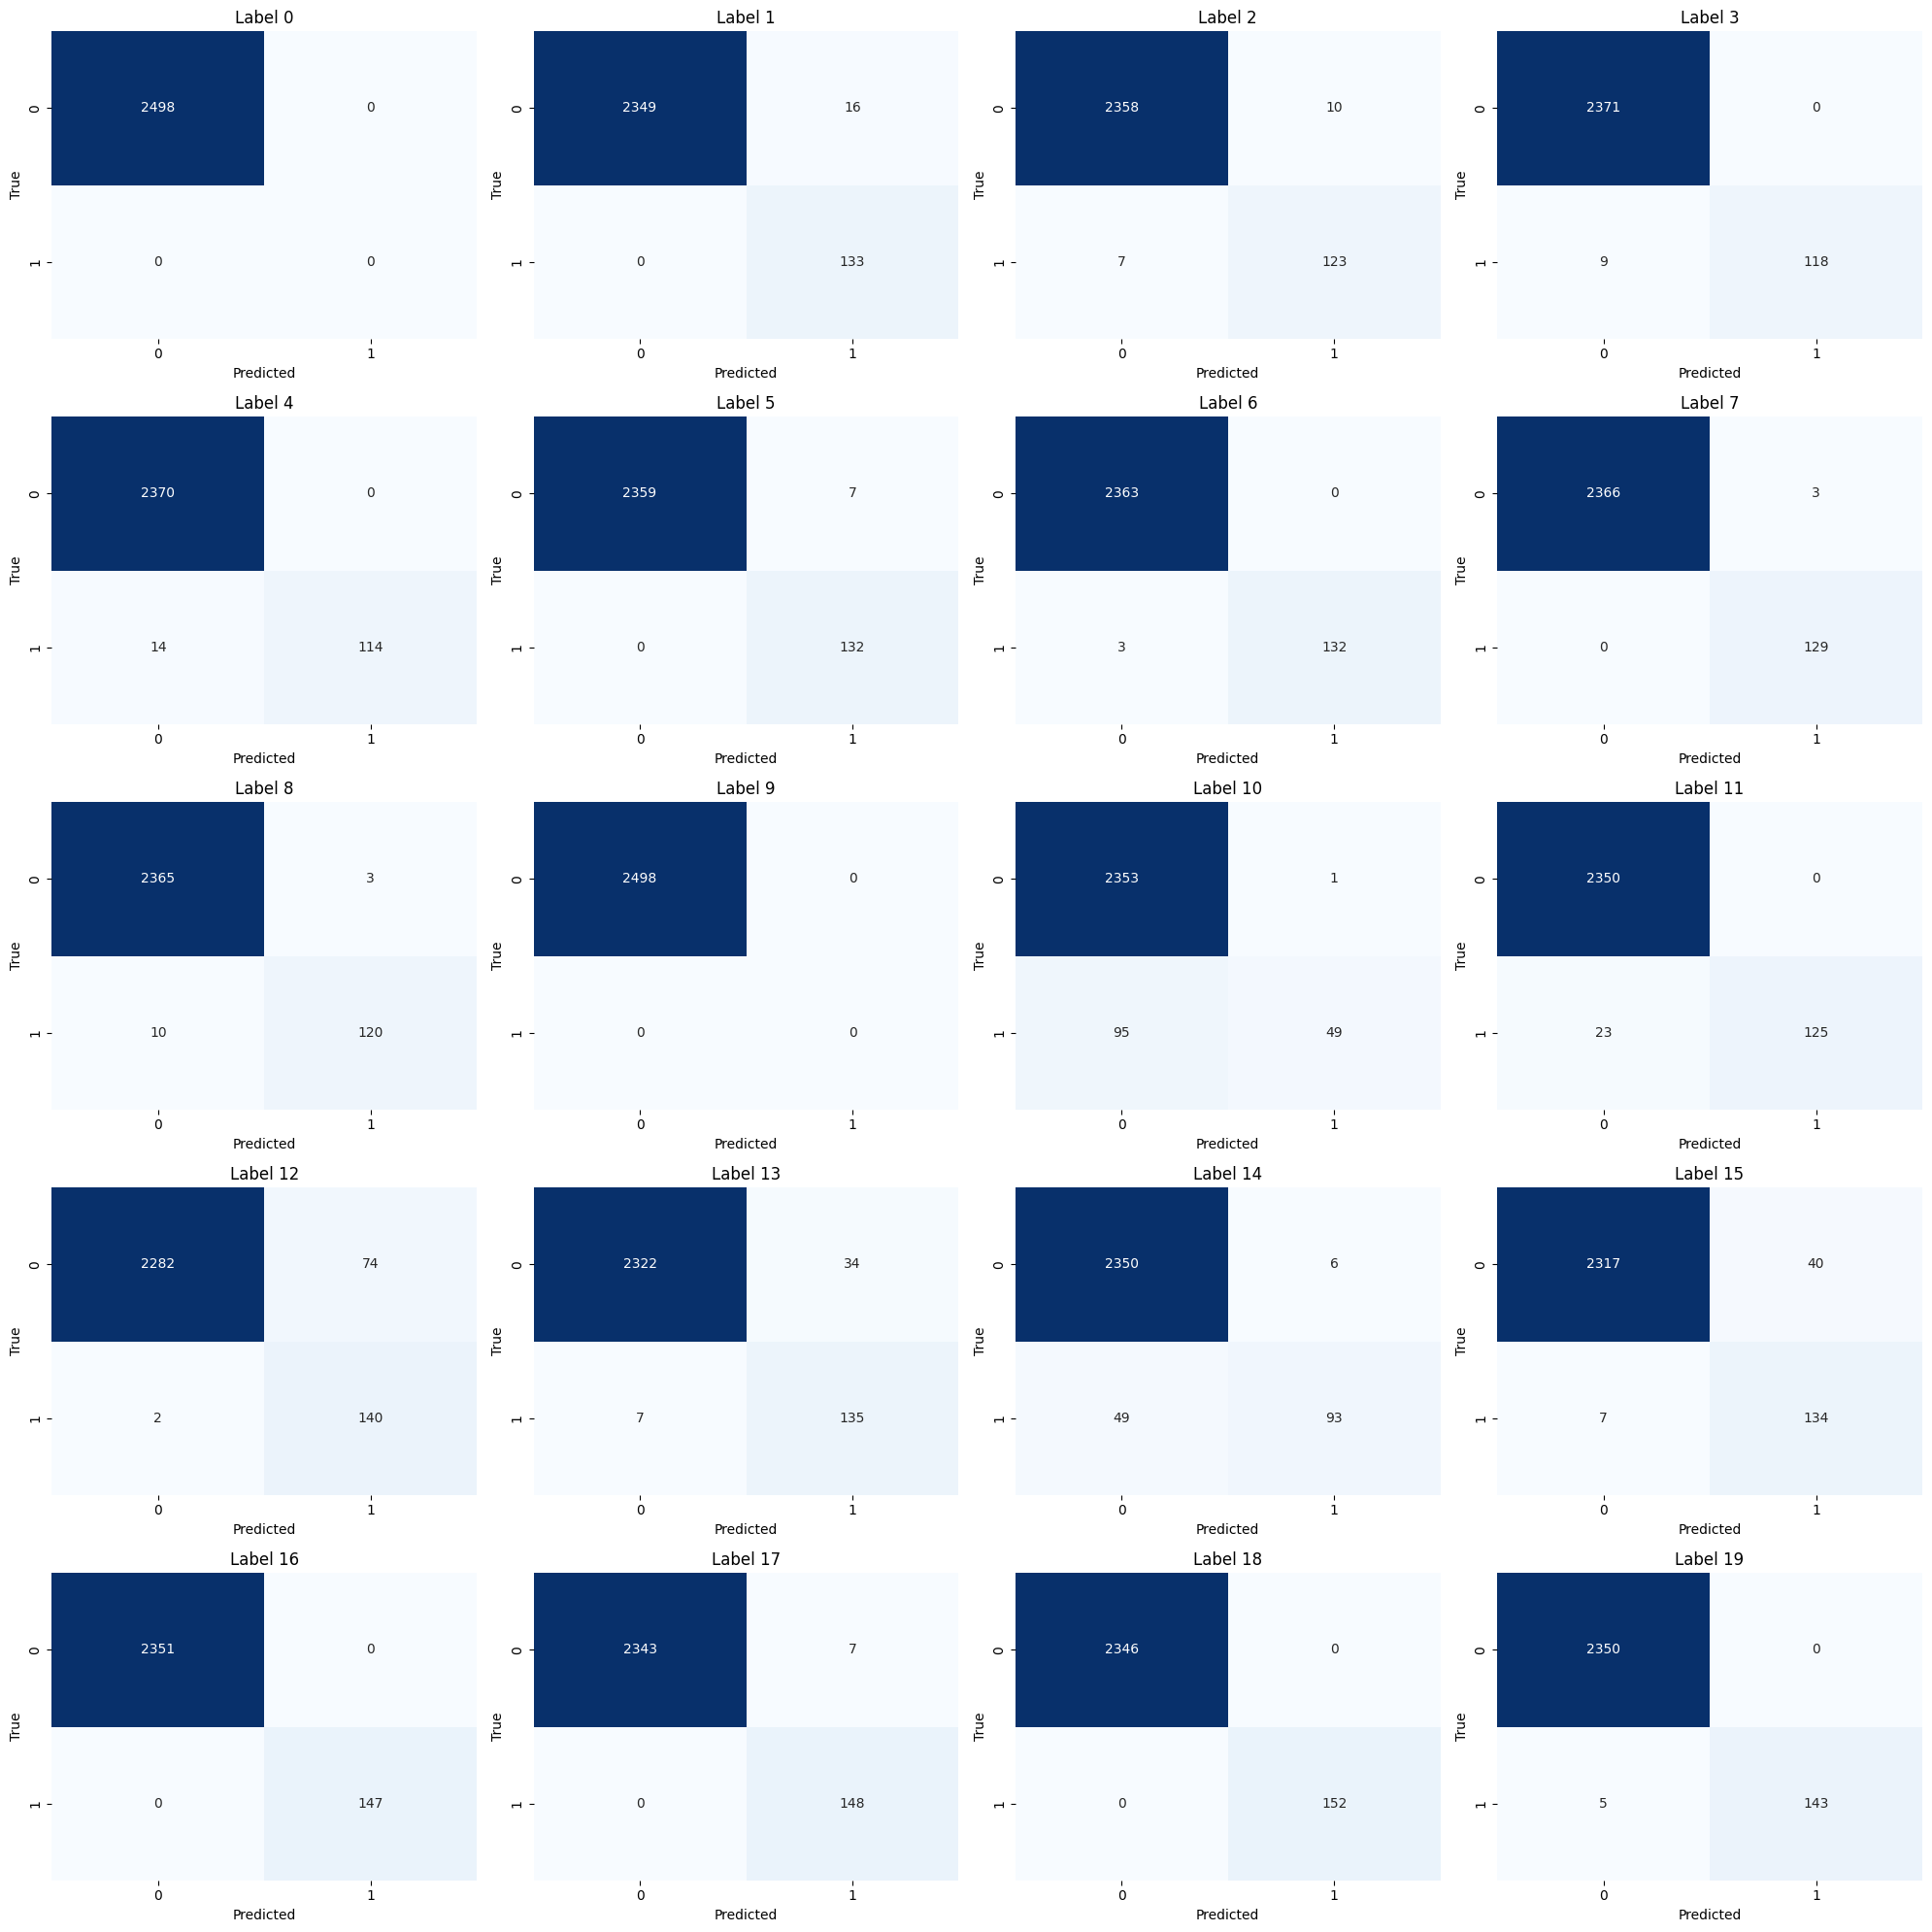

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Store predictions and labels
all_preds = []
all_labels = []

for i in range(len(batched_testing_dataset)):
    data = batched_testing_dataset[i]
    y = best_model(torch.stack(data).to(device))  # Forward
    y = custom_threshold_function(y).cpu()
    label = torch.stack(batched_label_dataset[i]).squeeze_().cpu()
    
    all_preds.append(y)
    all_labels.append(label)

# Stack into single arrays
all_preds_tensor = torch.cat(all_preds, dim=0).int()
all_labels_tensor = torch.cat(all_labels, dim=0).int()

# Compute confusion matrices per class
conf_matrices = multilabel_confusion_matrix(all_labels_tensor, all_preds_tensor)

# Plot each confusion matrix
n_labels = all_preds_tensor.shape[1]
fig, axes = plt.subplots(nrows=int(np.ceil(n_labels/4)), ncols=4, figsize=(20, 4 * int(np.ceil(n_labels/4))))
axes = axes.flatten()

for idx, cm in enumerate(conf_matrices):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Label {idx}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Hide any unused axes
for i in range(len(conf_matrices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


===== Multilabel Evaluation Metrics =====
Hamming Loss          : 0.0086
Subset Accuracy       : 0.9071
Micro Precision/Recall/F1 : 0.9186 / 0.9075 / 0.9130
Macro Precision/Recall/F1 : 0.8409 / 0.8180 / 0.8171
Example-based (Sample) F1 : 0.9074
===== Multilabel Evaluation Metrics =====
Hamming Loss              : 0.0086
Subset Accuracy           : 0.9071
Example-based Precision   : 0.9073
Example-based Recall      : 0.9075
Example-based F1-score    : 0.9074


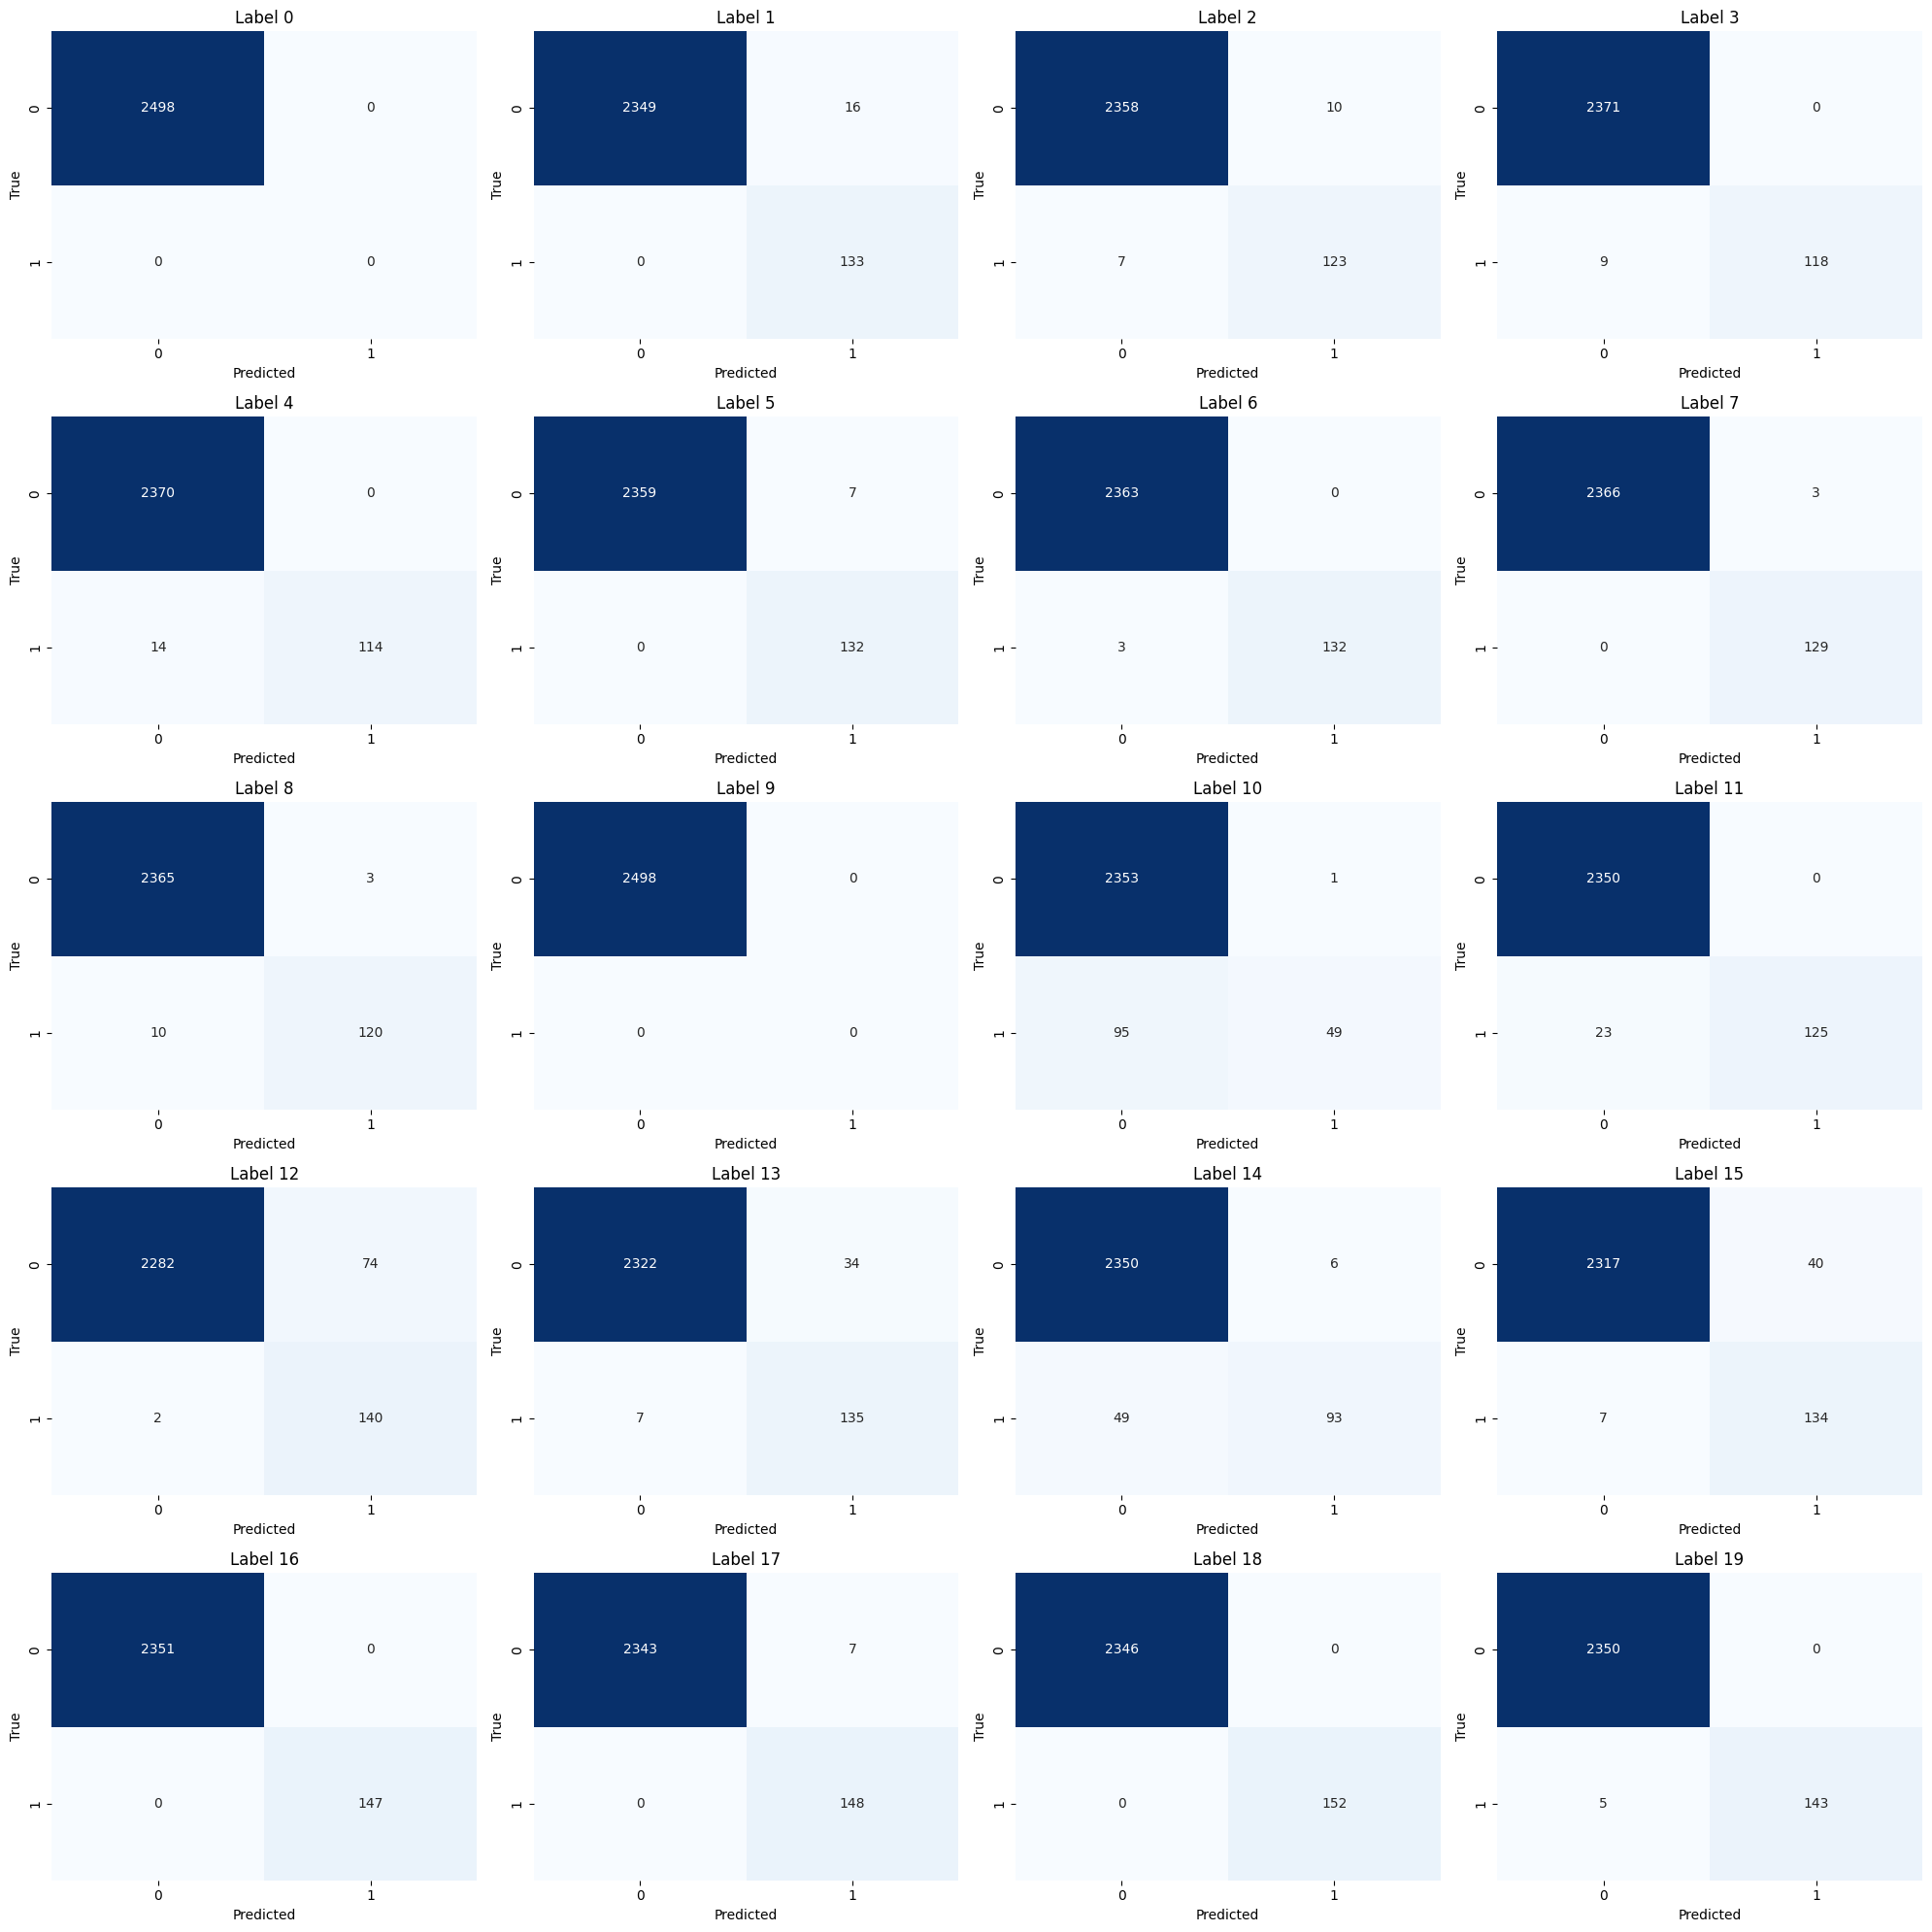

In [30]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    multilabel_confusion_matrix, hamming_loss, accuracy_score,
    f1_score, precision_score, recall_score
)

# Store predictions and labels
all_preds = []
all_labels = []

for i in range(len(batched_testing_dataset)):
    data = batched_testing_dataset[i]
    y = best_model(torch.stack(data).to(device))  # Forward
    y = custom_threshold_function(y).cpu()
    label = torch.stack(batched_label_dataset[i]).squeeze_().cpu()

    all_preds.append(y)
    all_labels.append(label)

# Stack into single arrays
all_preds_tensor = torch.cat(all_preds, dim=0).int()
all_labels_tensor = torch.cat(all_labels, dim=0).int()

# --- Evaluation Metrics ---

# Convert to NumPy
y_true = all_labels_tensor.numpy()
y_pred = all_preds_tensor.numpy()

# Hamming Loss
hamming = hamming_loss(y_true, y_pred)

# Subset Accuracy (Exact match)
subset_acc = accuracy_score(y_true, y_pred)

# Micro / Macro / Sample-based Precision, Recall, F1
micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

sample_f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)


# --- Print Metrics ---
print("===== Multilabel Evaluation Metrics =====")
print(f"Hamming Loss          : {hamming:.4f}")
print(f"Subset Accuracy       : {subset_acc:.4f}")
print(f"Micro Precision/Recall/F1 : {micro_precision:.4f} / {micro_recall:.4f} / {micro_f1:.4f}")
print(f"Macro Precision/Recall/F1 : {macro_precision:.4f} / {macro_recall:.4f} / {macro_f1:.4f}")
print(f"Example-based (Sample) F1 : {sample_f1:.4f}")


# Example-based metrics (per instance, averaged over all instances)
example_precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
example_recall = recall_score(y_true, y_pred, average='samples', zero_division=0)
example_f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)

# すでにあるその他の指標も保持
hamming = hamming_loss(y_true, y_pred)
subset_acc = accuracy_score(y_true, y_pred)

# --- Print metrics ---
print("===== Multilabel Evaluation Metrics =====")
print(f"Hamming Loss              : {hamming:.4f}")
print(f"Subset Accuracy           : {subset_acc:.4f}")
print(f"Example-based Precision   : {example_precision:.4f}")
print(f"Example-based Recall      : {example_recall:.4f}")
print(f"Example-based F1-score    : {example_f1:.4f}")


# --- Confusion Matrices (per label) ---
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)
n_labels = y_true.shape[1]
fig, axes = plt.subplots(nrows=int(np.ceil(n_labels / 4)), ncols=4, figsize=(20, 4 * int(np.ceil(n_labels / 4))))
axes = axes.flatten()

for idx, cm in enumerate(conf_matrices):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Label {idx}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Hide unused axes
for i in range(len(conf_matrices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
